In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
print(use_cuda)

False


In [97]:
"""
Reinforcement learning without going too deep.
"""

class SithSR(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 gamma=.9, alpha=.5, num_drifts=3,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt

        self._num_drifts = num_drifts

        self._gamma = gamma
        self._alpha = alpha

        self.history = None

        self._actions = torch.eye(action_len).type(FloatTensor)
        # init sith
        self._in_sith = state_len + action_len
        self._sith = SITH(self._in_sith, dt=self._dt, tau_0=self._info_rate, ntau=25, dtype=self._dtype, use_cuda=use_cuda)
        self._p0 = torch.zeros((self._state_len, 1)).type(FloatTensor)

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._state_len, self._in_M)).type(FloatTensor) # (outM, inM)

    def reset_T(self):
        self._sith.reset()

    def add_memory(self, reward):
        curr_history = torch.cat((self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                 1)
        if self.history is None:
            self.history = curr_history
        else:
            self.history = torch.cat((self.history, curr_history), 0)


    def _grab_goal(self, state):
        # Save current t for later
        t_save = self._sith._t.clone()

        # Pull out rewards and features from our history. They are needed
        # in seperate steps
        rewards = self.history[:,-1]
        rewarding = torch.zeros(self.history.size(0)).type(FloatTensor)
        historical_features = self.history[:, :-1]

        # Delay sith and find the reward values from the has table.
        for i in range(self._num_drifts):
            self._sith.update_t(item=None, dur=self._info_rate)
            feature_similarity = torch.mm(historical_features,
                                          self._sith.flatten_T().unsqueeze(1))
            # Take how closely related the historical features, and multiply
            # those by the rewards. This will tell use which history is the
            # closest to ours and the most rewarding.
            rewarding += feature_similarity.view(-1)*rewards
        # Return t to its previous
        self._sith._t = t_save
        self._sith._t_changed = True
        # Pull out the maximumly rewarding state of T from the hash table.
        # That is the goal for our actor
        out = self.history[rewarding.max(0)[1]][:,:-1]

        return out

    def pick_action(self, state):
        # try out various actions and get max reward
        goal_state = self._grab_goal(state)
        t_save = self._sith.t.clone()

        # try out each action
        potential_futures = None

        # we need to reset t to the old t every loop. &
        for a in self._actions:
            
            # update sith
            sa = torch.cat((state, a), 0)
            self._sith.update_t(sa, dur=self._dur)
            self._sith.update_t(item=None, dur=self._delay)

            # pass through M to get reward
            if potential_futures is None:
                potential_futures = self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)
            else:
                potential_futures = torch.cat((potential_futures,
                                               self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)),
                                              0)
            self._sith._t = t_save
            self._sith._t_changed = True
        evidence = potential_futures.mm(goal_state.view(-1, 1)[:self._in_sith-self._action_len])

        value, action_index = evidence.max(0)

        return action_index

    def learn_step(self, state, action):
        # turn into new sa1
        sa1 = torch.cat((state, self._actions[action].view(-1)), 0).unsqueeze(1)
        sa1_p = torch.cat((sa1, torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)).type(FloatTensor)), 0)
        #sa1_p = torch.cat((torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)).type(FloatTensor), sa1), 0)
        # calc prediction from new state
        p1 = self._M.mm(sa1_p)
        # update M based on prediction error
        #perr = state.unsqueeze(1) + self._gamma * p1 - self._p0
        perr = state.unsqueeze(1) - self._p0
        self._M += self._alpha * perr.mm(self._sith.T.unsqueeze(1).t())
        
        # update T with that state action
        self._sith.update_t(item=sa1.view(-1)*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)

        # prepare for next loop
        self._p0 = p1


In [98]:
# global params
height = 10
width=10
num_actions = 3
input_size = width * height

# how many games to train on every frame
games_per_frame = 10

masks = [0] #[0, 1, 2, 4, 8, 12, 16]

q_sizes = {'RL':[1]}
           #'queue': [1, 5, 10]}
mod_type = ["RL"]
num_runs = 1
model = SithSR(state_len=input_size, action_len=num_actions)

In [99]:
run_base = 'catch_long_lr'
#run_base = 'catch_MSE'
num_games = 10000
hidden_size = input_size * 1
per_random_act = .1
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=0, ball_spawn_rate=height+1,)

In [103]:
tot_score = 0.0

# train over total epochs
for e in range(num_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    
    #iterate over each game
    while not game_over:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()


        # Randomly pick an action, or use the
        # Previously calculated action
        """if (np.random.rand() <= per_random_act) or (model.history is None):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:"""
        action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        # t_0, current timestep
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
        if reward != 0:
            model.add_memory(reward)
            tot_score += reward
    print(e, ": ", tot_score)
    # Reset Game and Model Queue when the game is over.
    

0 :  -1.0
1 :  -2.0
2 :  -3.0
3 :  -4.0
4 :  -3.0
5 :  -4.0
6 :  -5.0
7 :  -6.0
8 :  -7.0
9 :  -8.0
10 :  -9.0
11 :  -10.0
12 :  -9.0
13 :  -10.0
14 :  -9.0
15 :  -10.0
16 :  -11.0
17 :  -10.0
18 :  -11.0
19 :  -12.0
20 :  -13.0
21 :  -12.0
22 :  -13.0
23 :  -14.0
24 :  -13.0
25 :  -14.0
26 :  -13.0
27 :  -12.0
28 :  -13.0
29 :  -14.0
30 :  -13.0
31 :  -14.0
32 :  -15.0
33 :  -16.0
34 :  -17.0
35 :  -18.0
36 :  -19.0
37 :  -20.0
38 :  -21.0
39 :  -20.0
40 :  -21.0
41 :  -22.0
42 :  -23.0
43 :  -24.0
44 :  -25.0
45 :  -26.0
46 :  -27.0
47 :  -28.0
48 :  -29.0
49 :  -30.0
50 :  -29.0
51 :  -28.0
52 :  -27.0
53 :  -28.0
54 :  -29.0
55 :  -30.0
56 :  -31.0
57 :  -32.0
58 :  -31.0
59 :  -32.0
60 :  -33.0
61 :  -34.0
62 :  -35.0
63 :  -36.0
64 :  -35.0
65 :  -34.0
66 :  -33.0
67 :  -34.0
68 :  -35.0
69 :  -36.0
70 :  -35.0
71 :  -36.0
72 :  -35.0
73 :  -34.0
74 :  -35.0
75 :  -36.0
76 :  -37.0
77 :  -38.0
78 :  -37.0
79 :  -38.0
80 :  -39.0
81 :  -40.0
82 :  -41.0
83 :  -42.0
84 :  -43.0
85 

611 :  -266.0
612 :  -267.0
613 :  -268.0
614 :  -267.0
615 :  -268.0
616 :  -267.0
617 :  -266.0
618 :  -267.0
619 :  -268.0
620 :  -269.0
621 :  -268.0
622 :  -269.0
623 :  -270.0
624 :  -269.0
625 :  -270.0
626 :  -269.0
627 :  -268.0
628 :  -267.0
629 :  -268.0
630 :  -269.0
631 :  -270.0
632 :  -271.0
633 :  -270.0
634 :  -271.0
635 :  -272.0
636 :  -273.0
637 :  -272.0
638 :  -273.0
639 :  -274.0
640 :  -275.0
641 :  -276.0
642 :  -277.0
643 :  -276.0
644 :  -277.0
645 :  -278.0
646 :  -279.0
647 :  -280.0
648 :  -281.0
649 :  -282.0
650 :  -283.0
651 :  -284.0
652 :  -285.0
653 :  -286.0
654 :  -287.0
655 :  -286.0
656 :  -287.0
657 :  -288.0
658 :  -289.0
659 :  -290.0
660 :  -289.0
661 :  -290.0
662 :  -289.0
663 :  -290.0
664 :  -291.0
665 :  -290.0
666 :  -291.0
667 :  -292.0
668 :  -293.0
669 :  -294.0
670 :  -293.0
671 :  -292.0
672 :  -291.0
673 :  -290.0
674 :  -289.0
675 :  -288.0
676 :  -289.0
677 :  -290.0
678 :  -291.0
679 :  -292.0
680 :  -293.0
681 :  -292.0
682 : 

KeyboardInterrupt: 

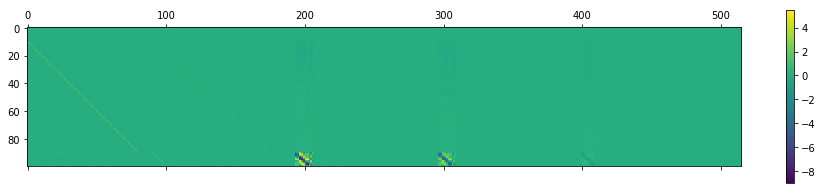

In [104]:
matshow(model._M.cpu().numpy())
colorbar()


In [105]:
model._M


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0007 -0.0135 -0.0127  ...   0.0212 -0.0144 -0.0052
 0.0523 -0.0255 -0.0116  ...   0.0226 -0.0042 -0.0169
-0.0188  0.0149  0.0054  ...   0.0275 -0.0216 -0.0071
[torch.FloatTensor of size 100x515]

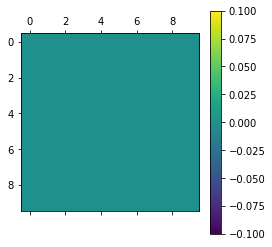

In [8]:
matshow(model._sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

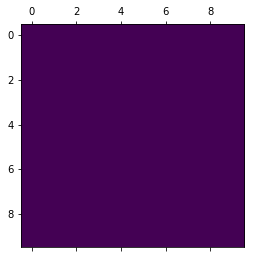

In [260]:
matshow(model._sith.T[103:203].view(10,10).cpu().numpy())

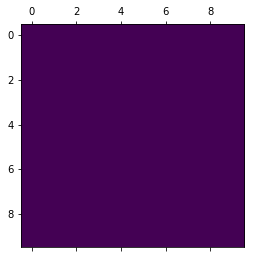

In [261]:
matshow(model._sith.T[206:306].view(10,10).cpu().numpy())

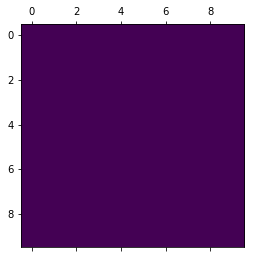

In [262]:
matshow(model._sith.T[0:100].view(10,10).cpu().numpy())

In [170]:
sith = SITH(103, dt=1./30./10., ntau=25, T_every=8, tau_0=1./30.,dtype=np.float32, use_cuda=use_cuda)
actions = torch.eye(3).type(FloatTensor)


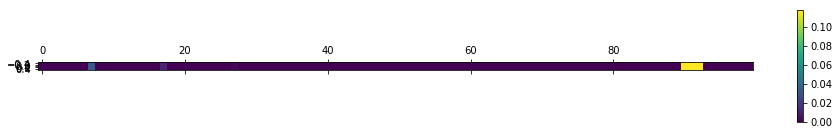

In [216]:
matshow(sith.T.unsqueeze(1).t().cpu().numpy()[:,-103:-3])
colorbar()

In [202]:
input_t = Tensor(c.observe(flatten=True))

In [203]:
input_t.view(10,10)


    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    1     1     1     0     0     0     0     0     0     0
[torch.cuda.FloatTensor of size 10x10 (GPU 0)]

In [204]:
sa1 = torch.cat((input_t, actions[0].view(-1)), 0).unsqueeze(1)


In [205]:
sith.update_t(item=sa1.view(-1), dur=1./30./10.)
sith.update_t(item=None, dur=(1./30.) - (1./30./10.))

In [206]:
reward, timestep, game_over = c.act(-1)

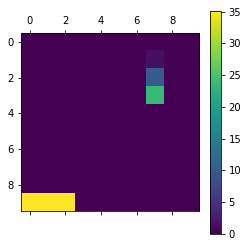

In [207]:
matshow(sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

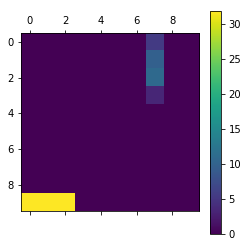

In [208]:
matshow(sith.T[103:203].view(10,10).cpu().numpy())
colorbar()

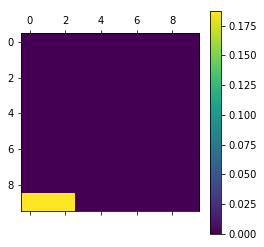

In [178]:
matshow(sith.T[206:306].view(10,10).cpu().numpy())
colorbar()

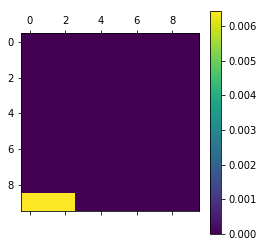

In [179]:
matshow(sith.T[309:409].view(10,10).cpu().numpy())
colorbar()

In [180]:
c.reset()

In [224]:
sith = SITH(103, dt=1./30./10., ntau=25, tau_0=1/30., dtype=np.float32, use_cuda=use_cuda)


In [294]:
sith.tau_star[sith._T_full_ind]

array([ 0.06830134,  0.14641   ,  0.31384283,  0.67275   ,  1.44209933,
        3.09126806], dtype=float32)

In [40]:
testing = torch.eye(5).type(FloatTensor)

In [41]:
model = SithSR(state_len=5, action_len=1)

In [72]:
model.learn_step(testing[4], 0)

In [67]:
model._sith.T


 23.5166
  0.0091
  0.1207
  1.3464
 10.1742
 35.1670
  4.3522
  2.3697
  5.4488
  9.8690
 11.2486
 33.2884
  5.9313
  6.7224
  7.0543
  6.5078
  5.4633
 31.6792
  3.9863
  3.5588
  3.0496
  2.5119
  2.0013
 15.1064
  0.6671
  0.5180
  0.3874
  0.2776
  0.1892
  2.0391
[torch.FloatTensor of size 30]

In [56]:
model._M



Columns 0 to 6 
    0.0046     0.0603     0.6732     5.0871    11.7580    17.5832     1.1800
    4.0194   -56.0119   -67.3105   849.7700  2283.6721  3014.1465   141.6460
    3.9939    -0.5987   -97.0327  -283.7577  -198.0655  -575.4628   -60.0349
    0.5933     4.0302    -0.0356   -89.1166  -205.9805  -290.5100   -15.7884
    0.0603     0.6732     5.0871    11.7580     0.0000    17.5787     2.7086

Columns 7 to 13 
    2.7086     4.8840     5.4696     1.7280    15.9701     2.6497     2.4810
  404.3288   863.9571  1042.0083   335.6210  2787.5212   464.5932   451.7972
 -126.1705  -174.4089  -121.2456   -29.1088  -510.9652   -85.6512   -71.7154
  -41.9801   -83.8318   -95.8187   -30.2720  -267.6874   -44.6356   -42.6875
    4.8840     5.4696     1.7280     0.0000    14.7903     2.4810     1.7819

Columns 14 to 20 
    1.7819     0.7759     0.0938     7.7820     0.5439     0.3266     0.1496
  335.8529   149.6034    18.2206  1420.0068   100.0485    61.1848    28.5233
  -43.0868   -14.6512

In [73]:
model._M.mm(st.view(-1, 1)).view(1, -1)


 5.1342e+08  1.0643e+11 -2.4570e+09 -9.2518e+09 -3.8862e+08
[torch.FloatTensor of size 1x5]

In [48]:
st = model._sith.T.clone()

In [74]:
st


  1.3464
 10.1741
 23.5160
  0.0000
  0.0000
 35.0366
  9.7680
 10.9393
  3.4560
  0.0000
  0.0000
 24.1633
  3.5637
  1.5519
  0.1876
  0.0000
  0.0000
  5.3036
  0.2991
  0.0826
  0.0064
  0.0000
  0.0000
  0.3881
  0.0124
  0.0028
  0.0002
  0.0000
  0.0000
  0.0154
[torch.FloatTensor of size 30]

In [76]:
model._sith.tau_star[model._sith._T_full_ind]

array([ 0.02276712,  0.04880333,  0.10461428,  0.22425   ,  0.48069978,
        1.03042269], dtype=float32)